In [1]:
import cv2
import numpy as np
from dlib_face_landmarks import get_face_landmarks
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import matplotlib as mpl

mpl.rc('image', cmap='gray')

In [2]:
def bgr2rgb(img: np.array):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def rgb2bgr(img: np.array):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

In [3]:
sample_img = "../face-samples/078.jpg"
mask_image = "facemask-images/n95_1.png"

## Load face image and find landmarks

In [4]:
image = bgr2rgb(cv2.imread(sample_img))
face_landmarks_list = get_face_landmarks(image)

## Landmarks visualization

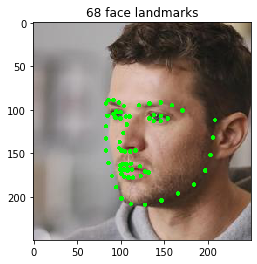

In [5]:
viz_image = image.copy()

for face_landmarks in face_landmarks_list:
    for facial_feature in face_landmarks.keys():
        for i, landmark in enumerate(face_landmarks[facial_feature]):
            point = np.array(landmark)
            viz_image = cv2.circle(viz_image, tuple(point), 1, (0, 255, 0), 2)
            
plt.title('68 face landmarks')
plt.imshow(viz_image)
plt.show()

## Selected landmarks

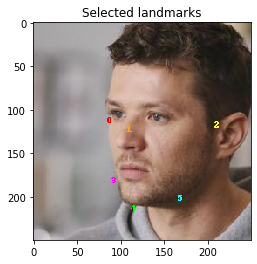

In [6]:
selected_landmarks_img = Image.fromarray(image)
d = ImageDraw.Draw(selected_landmarks_img)

face_landmarks = face_landmarks_list[0]
desired_landmarks = [face_landmarks['chin'][0], 
                     face_landmarks['nose_bridge'][1],
                     face_landmarks['chin'][16],
                     face_landmarks['chin'][5], 
                     face_landmarks['chin'][8],
                     face_landmarks['chin'][11],]

colors = ['red', 'orange', 'yellow', 'magenta', 'lime', 'cyan']
for i, landmark in enumerate(desired_landmarks):
    d.text(landmark, f"{i}", fill=colors[i])

plt.title('Selected landmarks')
plt.imshow(np.array(selected_landmarks_img))
plt.show()

In [7]:
img_face = rgb2bgr(image)
left_upper_chin = desired_landmarks[0]
nose_upper = desired_landmarks[1]
right_upper_chin = desired_landmarks[2]
left_lower_chin = desired_landmarks[3]
center_chin = desired_landmarks[4]
right_lower_chin = desired_landmarks[5]

## Split mask image

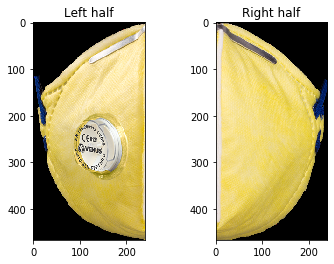

In [8]:
# Load face mask image
facemask = cv2.imread(mask_image, -1)

# Set middle location for split point
w_split = int(facemask.shape[1] / 2)

# Split into two halves
facemask_left = facemask[:, :w_split]
facemask_right = facemask[:, w_split:]

# Get half face mask image size
left_h, left_w = facemask_left.shape[:2]

ax = plt.subplot(1, 2, 1)
ax.set_title('Left half')
ax.imshow(cv2.cvtColor(facemask_left, cv2.COLOR_BGR2RGB))

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('Right half')
ax2.imshow(cv2.cvtColor(facemask_right, cv2.COLOR_BGR2RGB))
plt.show()

## Warp each halves

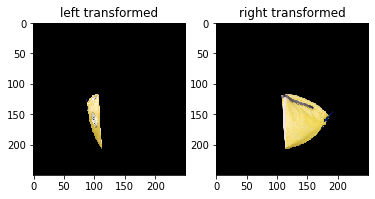

In [9]:
# Get original face image size
size_h, size_w = img_face.shape[:2]

# Four of the half face mask corners will be used as source points
input_pts = np.float32([[0, 0], [left_w, 0], [left_w, left_h],[0, left_h]])

# Warp left half face mask image
out_left_pts = np.float32([left_upper_chin, nose_upper, center_chin, left_lower_chin])
LM = cv2.getPerspectiveTransform(input_pts, out_left_pts)
left_out = cv2.warpPerspective(facemask_left, LM, (size_w, size_h),flags=cv2.INTER_LINEAR)
left_out_no_alpha = cv2.warpPerspective(facemask_left[:, :, 0:3], LM, (size_w, size_h),flags=cv2.INTER_LINEAR)

# Warp right half face mask image
out_right_pts = np.float32([nose_upper, right_upper_chin, right_lower_chin, center_chin])
RM = cv2.getPerspectiveTransform(input_pts, out_right_pts)
right_out = cv2.warpPerspective(facemask_right, RM, (size_w, size_h),flags=cv2.INTER_LINEAR)
right_out_no_alpha = cv2.warpPerspective(facemask_right[:, :, 0:3], RM, (size_w, size_h),flags=cv2.INTER_LINEAR)

# Vizualize
ax = plt.subplot(1, 2, 1)
ax.imshow(bgr2rgb(left_out_no_alpha))
ax.set_title('left transformed')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(bgr2rgb(right_out_no_alpha))
ax2.set_title('right transformed')
plt.show()

## Create binary mask and inverse binary mask

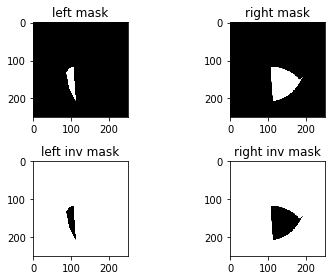

In [10]:
left_msk = left_out[:, :, 3]
left_msk_inv = cv2.bitwise_not(left_msk)

right_msk = right_out[:, :, 3]
right_msk_inv = cv2.bitwise_not(right_msk)

ax = plt.subplot(2, 2, 1)
ax.imshow(left_msk)
ax.set_title('left mask')

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(right_msk)
ax2.set_title('right mask')

ax3 = plt.subplot(2, 2, 3)
ax3.imshow(left_msk_inv)
ax3.set_title('left inv mask')

ax4 = plt.subplot(2, 2, 4)
ax4.imshow(right_msk_inv)
ax4.set_title('right inv mask')

plt.tight_layout()
plt.show()

## Combine face mask halves

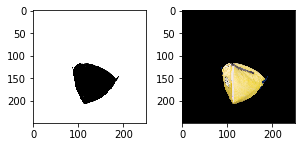

In [11]:
msk_inv = cv2.bitwise_and(left_msk_inv, right_msk_inv)
out = cv2.bitwise_or(left_out_no_alpha, right_out_no_alpha)

ax1 = plt.subplot(1, 3, 2)
ax1.imshow(msk_inv)
ax2 = plt.subplot(1, 3, 3)
ax2.imshow(bgr2rgb(out))

plt.tight_layout()
plt.show()

## Add the face mask to the face image background by using inverted mask

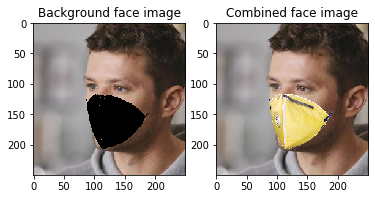

In [12]:
bg = cv2.bitwise_and(img_face, img_face, mask=msk_inv)
result = cv2.add(bg, out)

ax = plt.subplot(1, 2, 1)
ax.imshow(bgr2rgb(bg))
ax.set_title('Background face image')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(bgr2rgb(result))
ax2.set_title('Combined face image')

plt.show()